# Raw Evaluation wrt GT

In [182]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics
from evo.core import sync

from pose_trajectory_evaluation import PoseTrajectoryEvaluation

%reload_ext autoreload
%autoreload 2

In [294]:
export_path = '/media/berlukas/Data/data/cdpgo/v2/darpa/'
str_prefix = 'anymal_'
anymals = ['1','2','4','5']

compslam_trajectories = []
gt_trajectories = []
server_trajectories = []

for anymal in anymals:
    compslam_traj_filename = f'{export_path}{str_prefix}{anymal}_cs.npy'
    gt_traj_filename = f'{export_path}{str_prefix}{anymal}_gt.npy'
    server_traj_filename = f'{export_path}{str_prefix}{anymal}_srv8.npy'

    compslam_trajectories.append(np.load(compslam_traj_filename))
    gt_trajectories.append(np.load(gt_traj_filename))
    server_trajectories.append(np.load(server_traj_filename))
assert len(gt_trajectories) == len(compslam_trajectories)
assert len(gt_trajectories) == len(server_trajectories)


print(f'Loaded {len(gt_trajectories)} missions.')
print(f'GT poses: {gt_trajectories[0].shape[0]}')
print(f'Compslam poses: {compslam_trajectories[0].shape[0]}')
print(f'Server poses: {server_trajectories[0].shape[0]}')

Loaded 4 missions.
GT poses: 36962
Compslam poses: 14259
Server poses: 313810


In [ ]:
export_server_path = '/home/berlukas/Documents/results/h_floor_bkp/merged_map/'
# export_server_path = '/tmp/maplab_server/merged_map/'
csv_file = 'vertex_poses_velocities_biases.csv'
server_trajectories = []
eval = PoseTrajectoryEvaluation()

anymal_1_ms = '6b860e87b1969a160f00000000000000'
anymal_2_ms = 'ee0496a01b979a160f00000000000000'
anymal_2_ms_2 = 'ae2843fe27e69e160f00000000000000'


server_df = eval.get_mission_from_csv(export_server_path + csv_file, anymal_1_ms)
server_trajectories.append(eval.convert_df_to_traj(server_df))

print(f'Maplab poses: {server_trajectories[0].shape[0]}')

In [85]:
export_server_path = '/media/berlukas/Data/data/cdpgo/v2/darpa/'
csv_file = 'anymal_5_cs.csv'
server_trajectories = []
eval = PoseTrajectoryEvaluation()

anymal_2_ms = 'a9e15fbeefc2b4160f00000000000000'
anymal_4_ms = '32cb0f1897f1b4160f00000000000000'
anymal_5_ms = '268819b13df6b4160f00000000000000'

server_df = eval.get_mission_from_csv(export_server_path + csv_file, anymal_5_ms)
server_trajectories.append(eval.convert_df_to_traj(server_df))
print(f'Loaded {traj.shape[0]} poses.')

Loaded 1959 poses.


In [67]:
# Convert csv to npy
export_server_path = '/media/berlukas/Data/data/cdpgo/v2/darpa/'
csv_file = 'anymals2.csv'
server_trajectories = []
eval = PoseTrajectoryEvaluation()

anymal_1_ms = '67370194adb2b4160f00000000000000'
anymal_2_ms = 'a9e15fbeefc2b4160f00000000000000'
anymal_4_ms = '32cb0f1897f1b4160f00000000000000'
anymal_5_ms = 'dd6232da0440b5160f00000000000000'

server_df = eval.get_mission_from_csv(export_server_path + csv_file, anymal_5_ms)
traj = eval.convert_df_to_traj(server_df)
np.save(f'{export_server_path}anymal.npy', traj)
print(f'Wrote {traj.shape[0]} poses.')

Wrote 1959 poses.


------------------------------------------------------

In [208]:
max_diff = 0.1

delta = 10
delta_unit = metrics.Unit.frames
all_pairs = False

# skip the first few estimates due to the darpa alignment
# compslam_trajectories[0] = compslam_trajectories[0][10:,:]
# server_trajectories[0] = server_trajectories[0][5:,:]
# server_trajectories[0] = server_trajectories[0][0:len(server_trajectories[0])-255,:]

In [12]:
gt_trajectories[0] = gt_trajectories[0][0:len(gt_trajectories[0])-255,:]

In [295]:
def reduce(traj, n=10):
    init_size = traj.shape[0]
    traj = traj[::n, :]
    print(f'Reduced to {traj.shape[0]}/{init_size}')
    return traj
    
server_trajectories[0] = reduce(server_trajectories[0], 20)
server_trajectories[1] = reduce(server_trajectories[1], 20)
server_trajectories[2] = reduce(server_trajectories[2], 20)
server_trajectories[3] = reduce(server_trajectories[3], 20)

server_trajectories[0] = server_trajectories[0][750:,:]
server_trajectories[1] = server_trajectories[1][1000:,:]
server_trajectories[2] = server_trajectories[2][1000:,:]
server_trajectories[3] = server_trajectories[3][1000:,:]

Reduced to 15691/313810
Reduced to 42653/853047
Reduced to 26993/539856
Reduced to 29460/589184


In [140]:
def plot_evaluations_APE(data, ape_metric, ape_stats):
    # Trajectory plot
    fig = plt.figure(figsize=(8, 6), dpi=160)
    traj_by_label = {
        "estimate": data[1],
        "reference": data[0]
    }
    plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
    plt.show()

    # Trajectory plot
    seconds_from_start = [t - data[1].timestamps[0] for t in data[1].timestamps]
    fig = plt.figure(figsize=(8, 6), dpi=160)
    plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                     statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                     name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
    plt.show()

    plot_mode = plot.PlotMode.xy
    fig = plt.figure(figsize=(8, 6), dpi=160)
    ax = plot.prepare_axis(fig, plot_mode)
    plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
    plot.traj_colormap(ax, data[1], ape_metric.error, 
                       plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
    ax.legend()
    plt.show()

def perform_evaluation_using_data(data, delta, delta_unit, all_pairs):
    print('--- Translational Part -----------------------------')
    pose_relation = metrics.PoseRelation.translation_part
    print('APE:')
    ape_metric_trans = metrics.APE(pose_relation)
    ape_metric_trans.process_data(data)
    ape_stat_trans = ape_metric_trans.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_trans = ape_metric_trans.get_all_statistics()
    pprint.pprint(ape_stats_trans)

#     print('RPE:')
#     rpe_metric_trans = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_trans.process_data(data)
#     rpe_stat_trans = rpe_metric_trans.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_trans = rpe_metric_trans.get_all_statistics()
#     pprint.pprint(rpe_stats_trans)
#     print('\n\n')

    print('--- Rotational Part -----------------------------')
    pose_relation = metrics.PoseRelation.rotation_angle_deg
    print('APE:')
    ape_metric_rot = metrics.APE(pose_relation)
    ape_metric_rot.process_data(data)
    ape_stat_rot = ape_metric_rot.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_rot = ape_metric_rot.get_all_statistics()
    pprint.pprint(ape_stats_rot)

#     print('RPE:')
#     rpe_metric_rot = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_rot.process_data(data)
#     rpe_stat_rot = rpe_metric_rot.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_rot = rpe_metric_rot.get_all_statistics()
#     pprint.pprint(rpe_stats_rot)

    plot_evaluations_APE(data, ape_metric_trans, ape_stats_trans)

=== Maplab ===========================================================
--- Translational Part -----------------------------
APE:
{'max': 0.6071311975261913,
 'mean': 0.27050669846681336,
 'median': 0.25391660356565904,
 'min': 0.023096294797417358,
 'rmse': 0.30222814301280504,
 'sse': 1364.738587259219,
 'std': 0.13478863644073663}
--- Rotational Part -----------------------------
APE:
{'max': 4.3132431235280455,
 'mean': 1.5686847829444883,
 'median': 1.6145172677067854,
 'min': 0.10659315903623982,
 'rmse': 1.639442912433422,
 'sse': 40158.01733619816,
 'std': 0.4764463399865568}


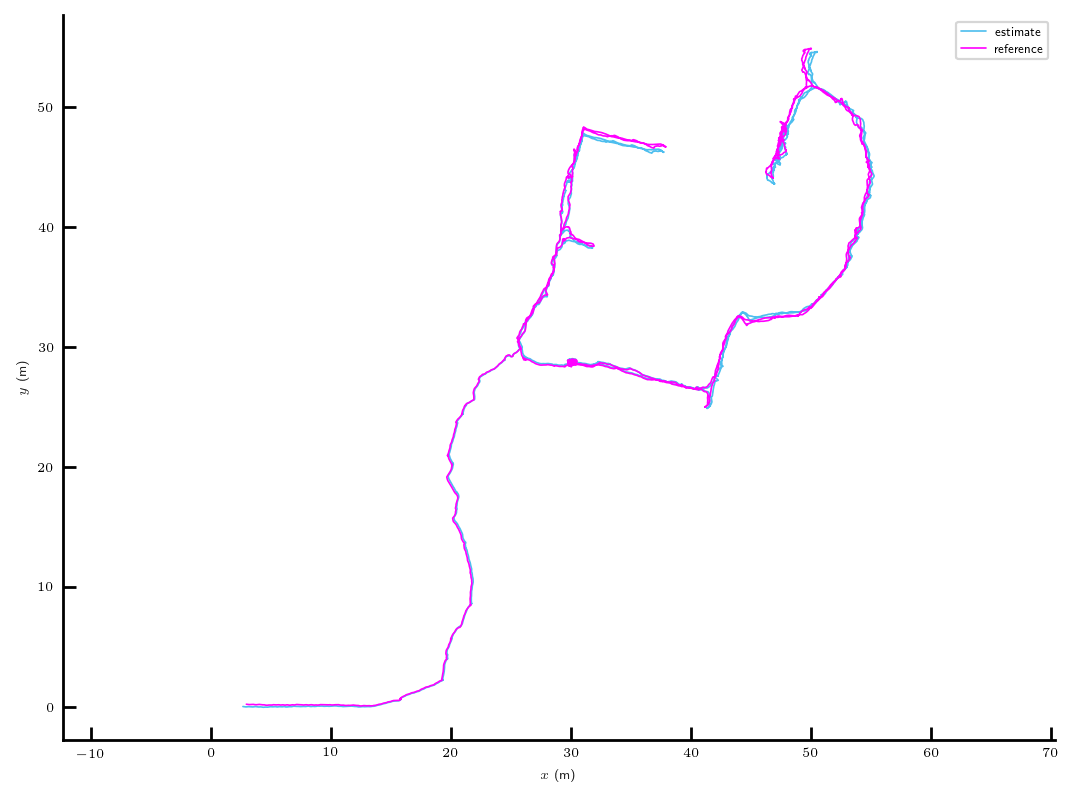

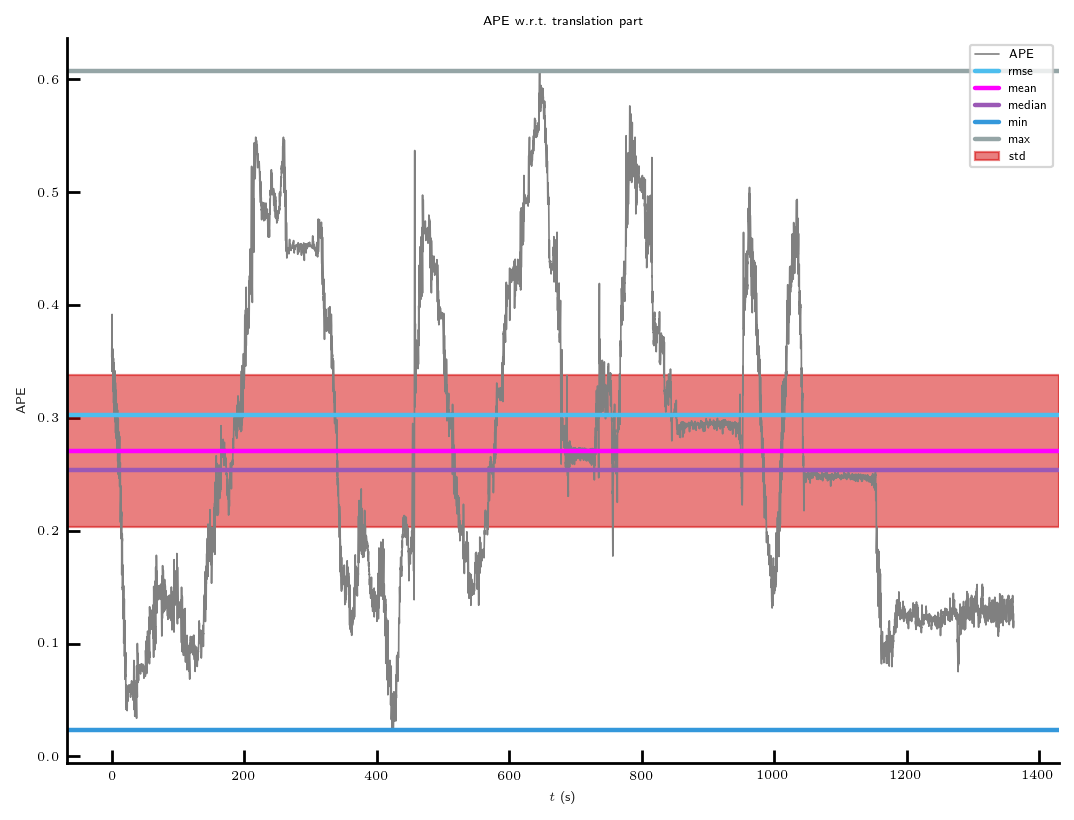

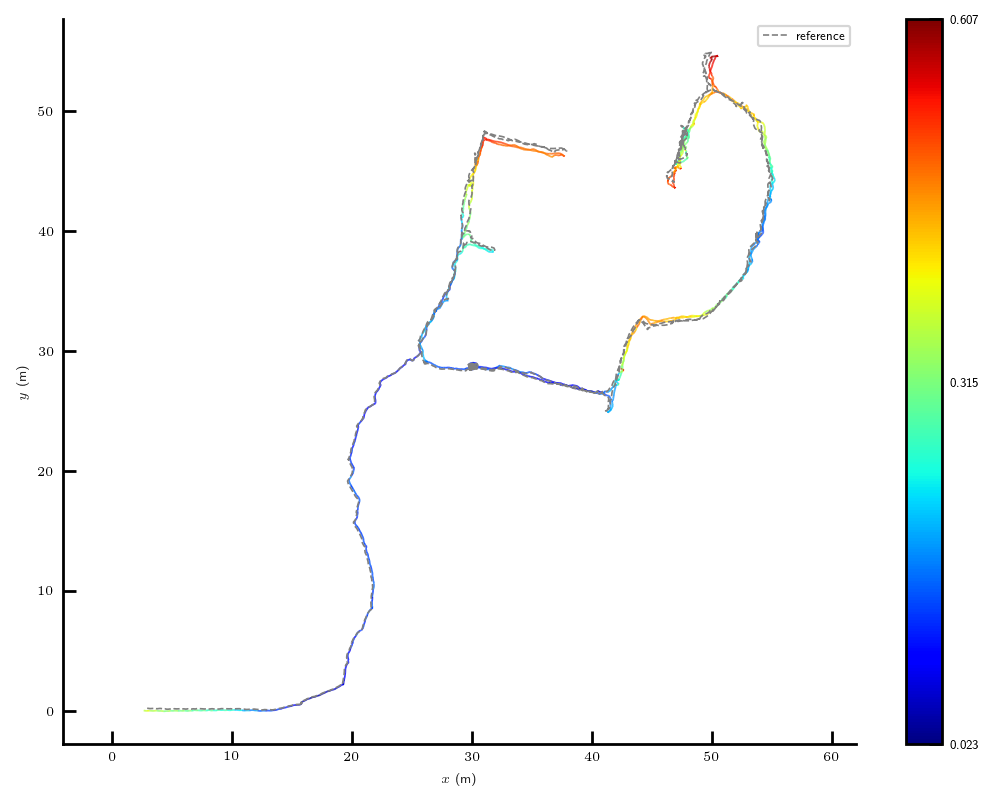

In [296]:
idx = 0

def ts_ns_to_seconds(ts_ns):
    k_ns_per_s = 1e9;
    return ts_ns / k_ns_per_s;

def convert_to_traj(trajectory):
    ts = ts_ns_to_seconds(trajectory[:,0])
    xyz = trajectory[:,1:4]
#     xyz = np.zeros((trajectory.shape[0],3))
#     xyz[:,0:2] = trajectory[:,1:3]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

# print(f'=== COMPSLAM =========================================================')
# compslam_traj = convert_to_traj(compslam_trajectories[idx])
# gt_traj = convert_to_traj(gt_trajectories[idx])
# gt_traj, compslam_traj = sync.associate_trajectories(gt_traj, compslam_traj, max_diff)
# compslam_traj.align(gt_traj, correct_scale=False, correct_only_scale=False, n=1000)

# data = (gt_traj, compslam_traj)
# perform_evaluation_using_data(data, delta, delta_unit, all_pairs)


print(f'=== Maplab ===========================================================')
server_traj = convert_to_traj(server_trajectories[idx])
gt_traj = convert_to_traj(gt_trajectories[idx])
gt_traj, server_traj = sync.associate_trajectories(gt_traj, server_traj, max_diff)
server_traj.align(gt_traj, correct_scale=False, correct_only_scale=False, n=1000)

data = (gt_traj, server_traj)
perform_evaluation_using_data(data, delta, delta_unit, all_pairs)

In [ ]:
server_traj.align(gt_traj, correct_scale=False, correct_only_scale=False, n=1000)
data = (gt_traj, server_traj)
perform_evaluation_using_data(data, delta, delta_unit, all_pairs)

In [180]:
server_tum = np.column_stack((server_traj.timestamps, server_traj.positions_xyz, server_traj.orientations_quat_wxyz[:, [1,2,3,0]]))
print(f'Converted estimated trajectory to TUM ({server_tum.shape}).')
export_path = '/tmp/est_tum.csv'
# np.save(export_path, server_tum)
np.savetxt(export_path, server_tum, delimiter=" ", fmt='%f')
print(f'Wrote converted trajectory to {export_path}')

Converted estimated trajectory to TUM ((23227, 8)).
Wrote converted trajectory to /tmp/est_tum.csv


In [181]:
server_tum.shape[0]/2577

9.013193636010865